## 데이터 준비하기

In [29]:
import pandas as pd
# 판다스 출력 결과를 소수점 둘째 자리 까지로 제한
pd.options.display.float_format = '{:,.2f}'.format
# 고객 254명의 상품 구매 관련 데이터 불러오기
sales_df = pd.read_csv('data/sales_data.csv', index_col=0)
sales_df.head()

,total_buy_cnt,total_price
customer_id,,
12395,99,430250
12427,98,566410
12431,122,849900
12433,625,1180950
12471,10,97750


In [30]:
# 데이터 개수 확인
sales_df.shape

(254, 2)

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

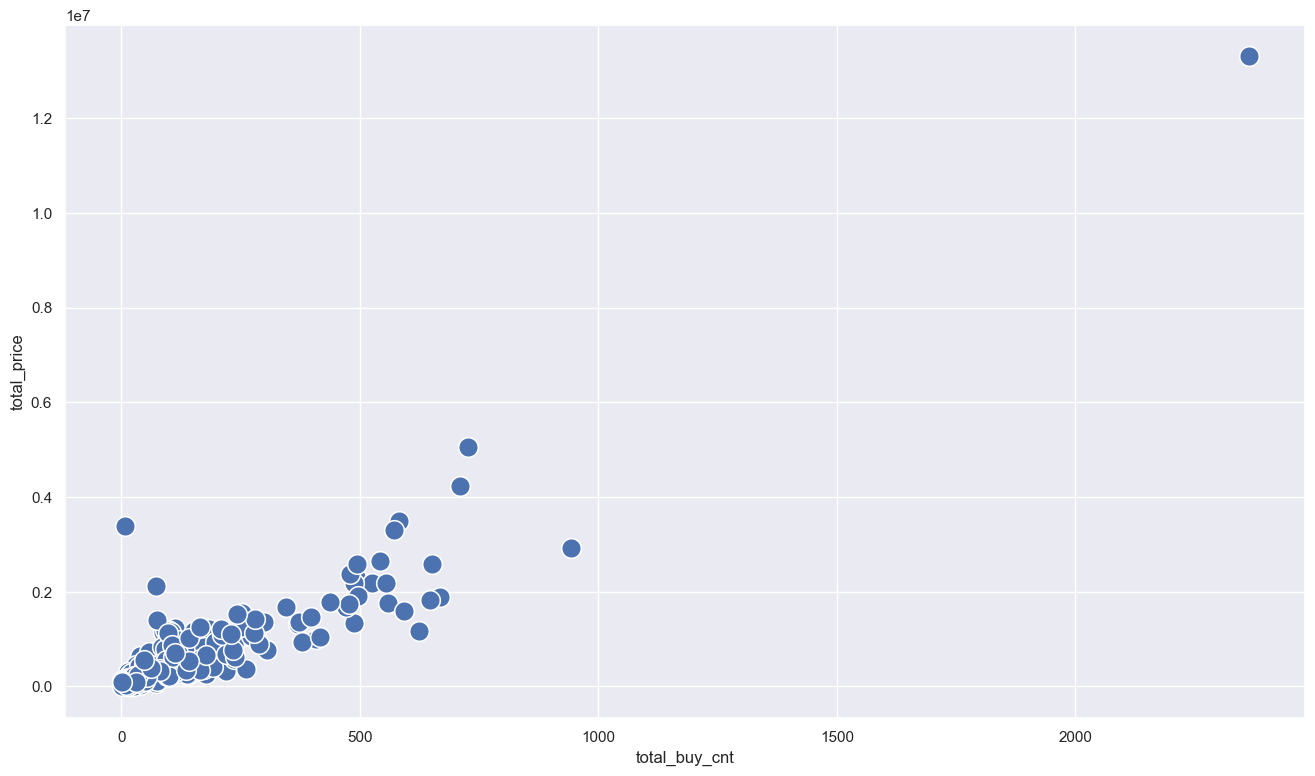

In [31]:
# 데이터 분포 확인
import seaborn as sns
sns.set(style="darkgrid",
        rc={'figure.figsize':(16,9)})

# 데이터 시각화
sns.scatterplot(x=sales_df['total_buy_cnt'], y=sales_df['total_price'], s=200)

#### 이상치 제거

In [32]:
# 이상치 제거 함수
def get_outlier(df):   
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1

    range_min = Q1 - IQR * 1.5
    range_max = Q3 + IQR * 1.5

    outlier_per_column = (df < range_min) | (df > range_max)
    
    # any(axis=1): 각 행에 대해 하나라도 True 값이 있으면 True를 반환
    is_outlier = outlier_per_column.any(axis=1)

    return is_outlier

Index([12433, 12838, 13013, 13145, 13705, 14083, 14449, 14573, 14729, 14911,
       15012, 15061, 15525, 15574, 15862, 16244, 16274, 16891, 16916, 17198,
       17238, 17841, 17850, 17908, 17920, 17967, 17968, 17976, 18041],
      dtype='int64', name='customer_id')


<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

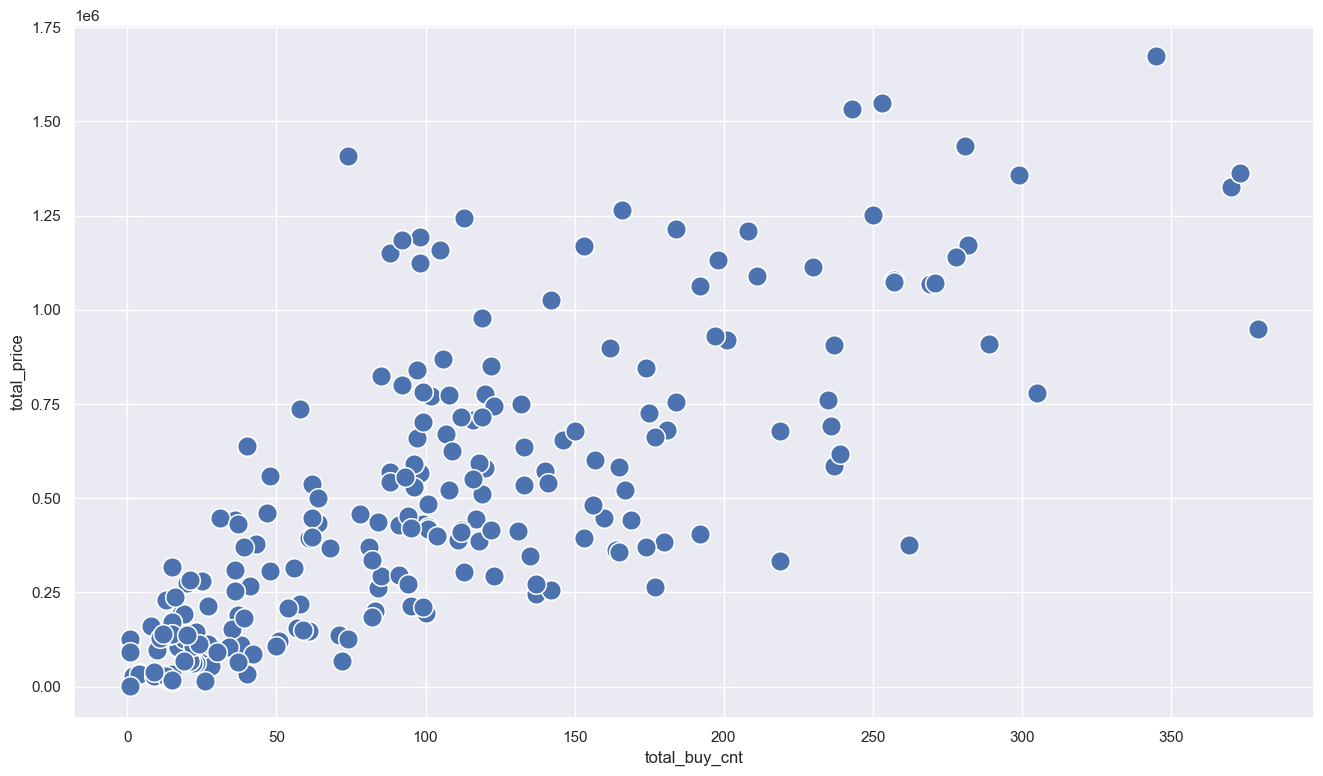

In [33]:
# 이상치 
outlier_df = get_outlier(sales_df)

# 이상치 인덱스 추출
outlier_index = sales_df[outlier_df].index
print(outlier_index)

# 이상치 제거
sales_df = sales_df.drop(outlier_index)

# 이상치 제거한 데이터프레임 시각화
sns.scatterplot(x=sales_df['total_buy_cnt'], y=sales_df['total_price'], s=200)

#### 데이터 표준화(Standardization)
- 데이터를 보면 total_buy_cnt는 단위가 1개이고, 가장 큰 값은 350개입니다. 하지만, total_price는 기본 단위가 10,000원입니다. 두 변수의 단위 통일이 필요

In [34]:
df_mean = sales_df.mean()  # 각 컬럼의 평균값
df_std = sales_df.std()  # 각 컬럼의 표준편차

scaled_df = (sales_df - df_mean)/df_std  # 컬럼별 표준화 진행
scaled_df

,total_buy_cnt,total_price
customer_id,,
12395,-0.05,-0.15
12427,-0.07,0.21
12431,0.23,0.95
12471,-1.13,-1.02
12472,-0.19,0.21
...,...,...
18144,-0.89,-1.04
18168,1.69,2.74
18225,-1.24,-1.04
